In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4

In [14]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import Dataset
import re
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import numpy as np

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Download stopwords and wordnet data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load and Inspect Dataset

In [5]:
# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/Dataset/Technical Test/mtsamples.csv")

# Drop rows with null values in the 'text' column
data.dropna(subset=['text'], inplace=True)
data

,text,label
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Bariatrics
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary
...,...,...
4994,"HISTORY:, I had the pleasure of meeting and e...",Allergy / Immunology
4995,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...",Allergy / Immunology
4996,"SUBJECTIVE: , This is a 42-year-old white fema...",Allergy / Immunology
4997,"CHIEF COMPLAINT: , This 5-year-old male presen...",Allergy / Immunology


#Data Preprocessing

In [6]:
data['label'] = data['label'].str.lower()  # Convert to lowercase for consistency

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])

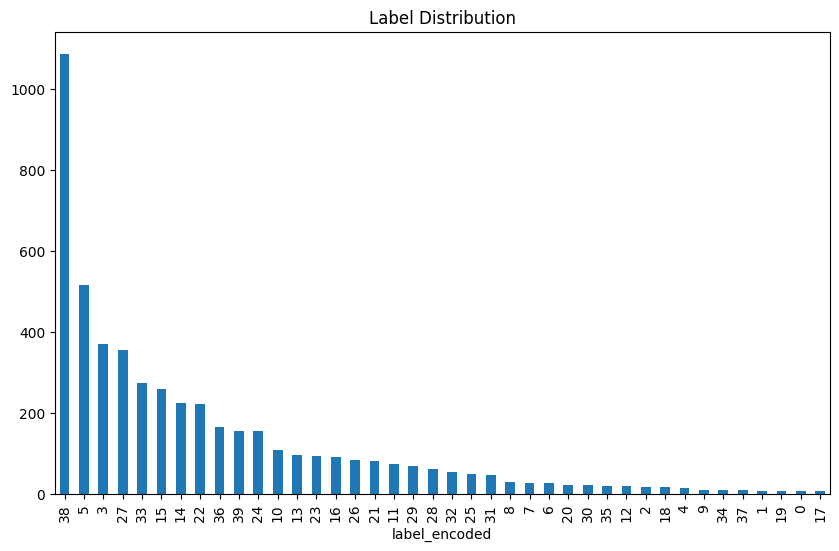

In [8]:
import matplotlib.pyplot as plt

label_counts = data['label_encoded'].value_counts()
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.show()

In [17]:
# Print initial data count
print(f'Initial data count: {len(data)}')

Initial data count: 4966


##Handling Imbalanced

In [9]:
# Extract features and labels
texts = data['text'].tolist()
labels = data['label_encoded'].tolist()

In [10]:
# Tokenization using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(texts)

In [11]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, labels)

In [12]:
# Convert resampled features back to list of strings
texts_resampled = vectorizer.inverse_transform(X_resampled)
texts_resampled = [' '.join(text) for text in texts_resampled]

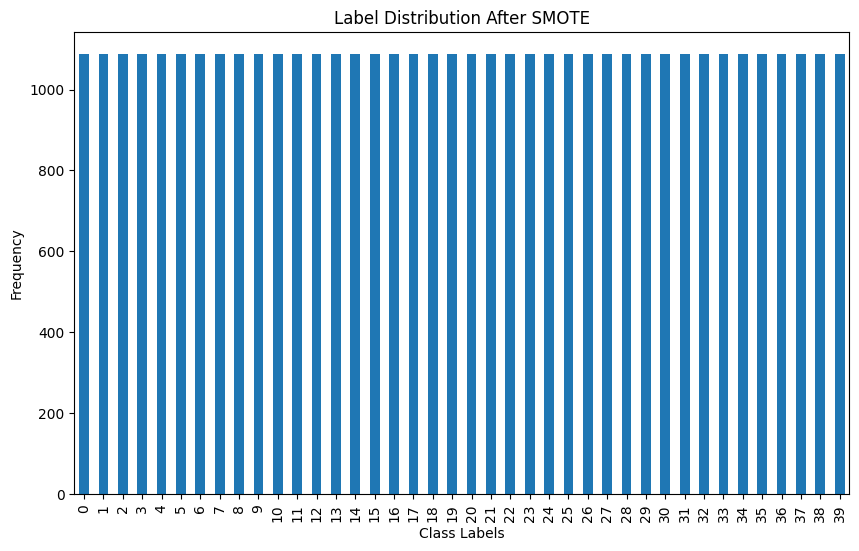

In [15]:
# Plot the new class distribution after SMOTE
unique, counts = np.unique(y_resampled, return_counts=True)
resampled_counts = pd.Series(counts, index=unique)

plt.figure(figsize=(10, 6))
resampled_counts.plot(kind='bar')
plt.title('Label Distribution After SMOTE')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Print data count after SMOTE
print(f'Data count after SMOTE: {len(y_resampled)}')

Data count after SMOTE: 43520


In [18]:
# Sample 5000 data points from the resampled dataset
sample_size = 5000
indices = np.random.choice(len(y_resampled), sample_size, replace=False)
X_sampled = X_resampled[indices]
y_sampled = np.array(y_resampled)[indices]

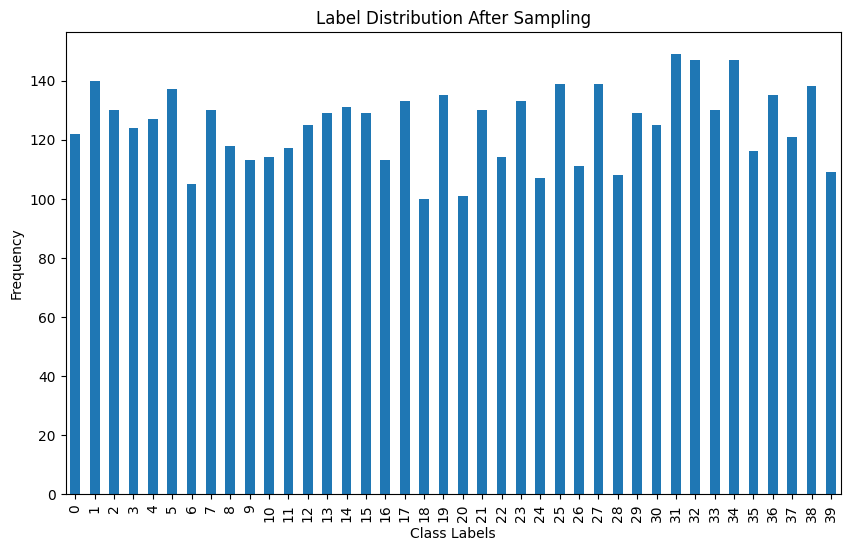

In [20]:
# Plot the new class distribution after sampling
unique, counts = np.unique(y_sampled, return_counts=True)
sampled_counts = pd.Series(counts, index=unique)

plt.figure(figsize=(10, 6))
sampled_counts.plot(kind='bar')
plt.title('Label Distribution After Sampling')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.show()

In [21]:
# Convert sampled features back to list of strings for tokenization
texts_sampled = vectorizer.inverse_transform(X_sampled)
texts_sampled = [' '.join(text) for text in texts_sampled]

In [22]:
# Tokenization for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokens_sampled = tokenizer(texts_sampled, padding=True, truncation=True, return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [23]:
# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(tokens_sampled['input_ids'], y_sampled, test_size=0.2, random_state=42)

In [24]:
# Create datasets
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [25]:
train_dataset = TextDataset({'input_ids': train_texts}, train_labels)
test_dataset = TextDataset({'input_ids': test_texts}, test_labels)

In [26]:
# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(labels)))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",         # Save model at the end of each epoch
    load_best_model_at_end=True,   # Load the best model at the end of training
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [29]:
# Train and evaluate
trainer.train()
trainer.evaluate()

<ipython-input-24-fbdcd06db4cc>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch,Training Loss,Validation Loss
1,2.649600,2.530760
2,1.182200,1.267416
3,0.854400,0.942222


<ipython-input-24-fbdcd06db4cc>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-24-fbdcd06db4cc>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-24-fbdcd06db4cc>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-24-fbdcd06db4cc>:8: UserWarning: To copy construct from a 

{'eval_loss': 0.9422220587730408,
 'eval_runtime': 27.1337,
 'eval_samples_per_second': 36.855,
 'eval_steps_per_second': 4.607,
 'epoch': 3.0}